In [1]:
from gwdistributions import parse, generators
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import copy
from convert_pdbNG_betaSplit_brokenG import get_variables, cartesian
import numpy as np
import pickle
import json

import sys
sys.path.append('../../../sampler/runs/pdbNG_betaSplit_brokenG_1_full/config')
from mass1d_func import pdb_with_NG
from spin_func import prob_chi_single, prob_costilt_single, brokenG

In [2]:
# read conversion_paths
with open("conversion_paths.txt", "r") as f:
    lines = f.readlines()
    priors_path = lines[0]
    mass_model_path = lines[1]
    spin_model_path = lines[2]

# read posterior_samples_fixed.json, conversion_dict.json and inv.json as dictionaries:
with open("posterior_samples_fixed.json", "r") as f:
    posterior_samples_fixed = json.load(f)
with open("conversion_dict.json", "r") as f:
    conversion_dict = json.load(f)
with open("conversion_dict_inv.json", "r") as f:
    inv = json.load(f)


# read merged_posterior_samples.pkl
with open("merged_posterior_samples.pkl", "rb") as f:
    unpickler = pickle.Unpickler(f)
    merged_posterior_samples = unpickler.load()

with open("converted_posterior_samples.pkl", "rb") as f:
    unpickler = pickle.Unpickler(f)
    samples = unpickler.load()

mass_func = pdb_with_NG
spin_func = brokenG
chi_func = prob_chi_single
costilt_func = prob_costilt_single

/opt/anaconda3/envs/mmms-gw230529/lib/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))


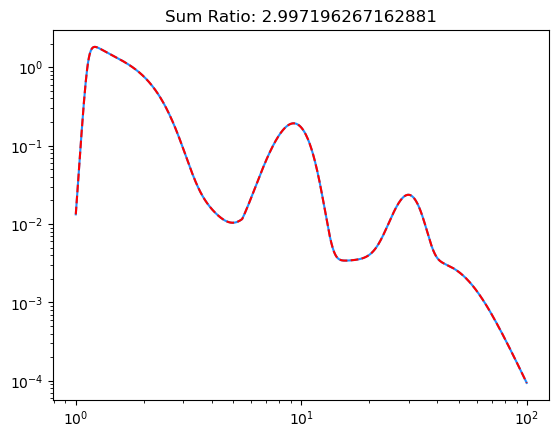

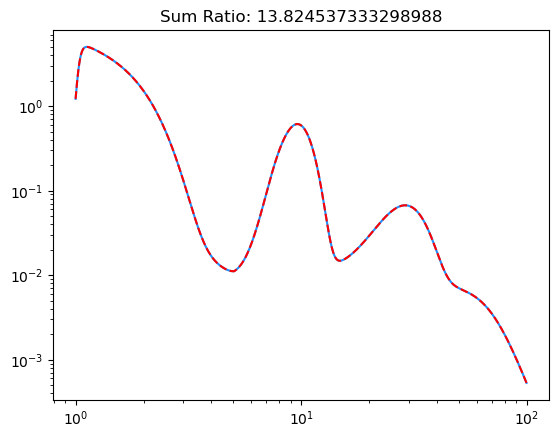

In [3]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist
var_lst = list(mass_func.__code__.co_varnames[:mass_func.__code__.co_argcount])
var_lst.remove("m")

# np.random.seed(5)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    # mass_grid = 9
    mass_grid = np.logspace(0, 1.999, 1000)

    # gw-distributions
    p_m = mass_dist1d.prob(mass_grid)
    # p_m = p_m / np.sum(p_m)  # Normalize the distribution

    # my code
    vals_lst = []
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                vals_lst.append(merged_posterior_samples[old_key][idx])

    vals_lst = np.array(vals_lst)

    for i in range(len(var_lst)):
        if var_lst[i] in ["peak_constant1", "peak_constant2", "peak_constant_NS"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    p_m_me = pdb_with_NG(mass_grid, *vals_lst)

    # Compute error list
    ratio = p_m/p_m_me
    error_lst.append(np.sum(ratio))

    plt.title(f"Sum Ratio: {np.sum(p_m/p_m_me)}")
    plt.plot(mass_grid, p_m_me * ratio[0], color = "dodgerblue")
    plt.plot(mass_grid, p_m, color = "red", linestyle = "dashed")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

error_lst = np.array(error_lst)

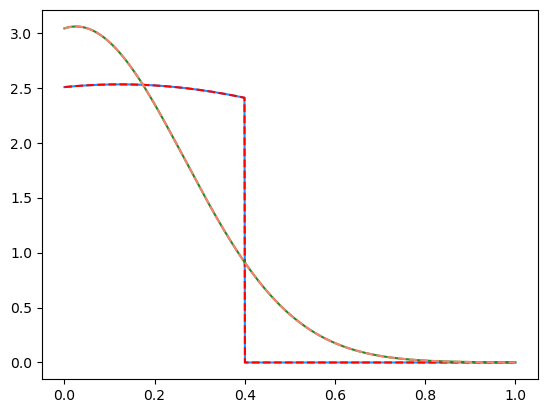

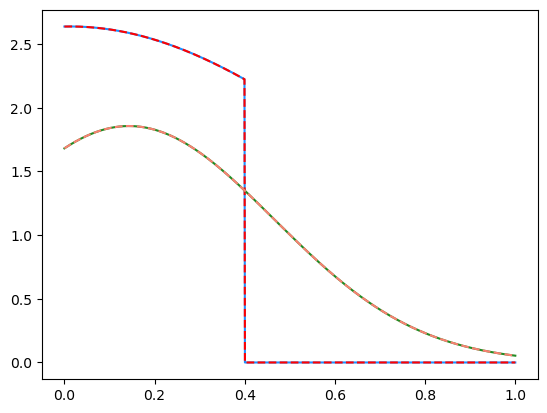

In [4]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
mag_dist = EG.variate2distribution("spin1_magnitude")
var_lst = list(spin_func.__code__.co_varnames[:spin_func.__code__.co_argcount])
var_lst = list(filter(lambda x: x not in ["mass1_source", "mass2_source", "a1", "costilt1", "a2", "costilt2"], var_lst))

# np.random.seed(5)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst_lower = []
error_lst_upper = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    a_grid = np.linspace(0, 1, 1000)

    # gw-distributions
    p_a_lower = mag_dist.prob(a_grid, 1)
    p_a_upper = mag_dist.prob(a_grid, 10)

    # my code
    vals_lst = []
    var_lst_copy = var_lst.copy()
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                if element not in var_lst_copy:
                    continue # Dont append more than once
                vals_lst.append(merged_posterior_samples[old_key][idx])
                var_lst_copy.remove(element)

    assert var_lst_copy == [], f"Not all variables were appended: {var_lst_copy}"


    vals_lst = np.array(vals_lst)
    for i in range(len(var_lst)):
        if var_lst[i] in ["mix_tilt1", "mix_tilt2"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    _f = lambda item: vals_lst[var_lst.index(f"{item}")]


    p_a_me_lower = prob_chi_single(a_grid, _f("mu_chi1"), _f("sig_chi1"), _f("a_min"), _f("a_max_NS"))
    p_a_me_upper = prob_chi_single(a_grid, _f("mu_chi2"), _f("sig_chi2"), _f("a_min"), _f("a_max"))

    # Compute error list
    ratio_lower = p_a_lower/p_a_me_lower
    ratio_upper = p_a_me_upper/p_a_me_upper
    error_lst_lower.append(np.sum(ratio_lower))
    error_lst_upper.append(np.sum(ratio_upper))

    plt.plot(a_grid, p_a_me_lower * ratio_lower[0], color = "dodgerblue")
    plt.plot(a_grid, p_a_lower, color = "red", linestyle = "dashed")
    plt.plot(a_grid, p_a_me_upper * ratio_upper[0], color = "forestgreen")
    plt.plot(a_grid, p_a_upper, color = "salmon", linestyle = "dashed")
    plt.show()

error_lst_lower = np.array(error_lst_lower)
error_lst_upper = np.array(error_lst_upper)

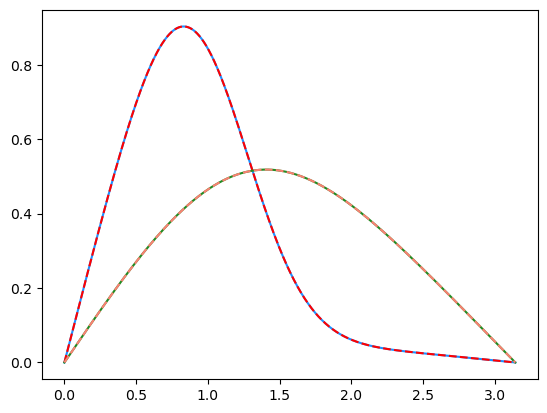

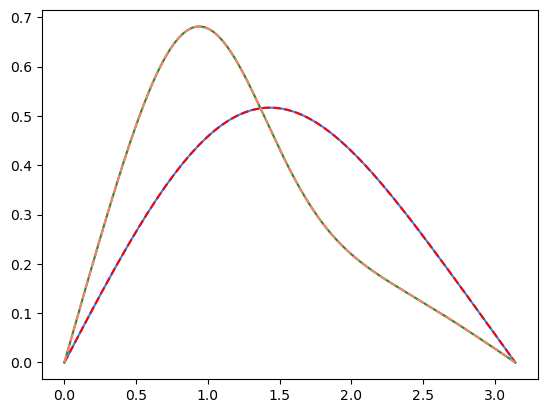

In [5]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
tilt_dist = EG.variate2distribution("spin1_polar_angle")
var_lst = list(spin_func.__code__.co_varnames[:spin_func.__code__.co_argcount])
var_lst = list(filter(lambda x: x not in ["mass1_source", "mass2_source", "a1", "costilt1", "a2", "costilt2"], var_lst))

np.random.seed(3)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst_lower = []
error_lst_upper = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    delta = 1e-6
    tg = np.linspace(0 + delta, np.pi - delta, 1000)
    cos_tg = np.cos(tg)

    # gw-distributions
    p_tilt_lower = tilt_dist.prob(tg, 1)
    p_tilt_upper = tilt_dist.prob(tg, 10)

    # my code
    vals_lst = []
    var_lst_copy = var_lst.copy()
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                if element not in var_lst_copy:
                    continue # Dont append more than once
                vals_lst.append(merged_posterior_samples[old_key][idx])
                var_lst_copy.remove(element)

    assert var_lst_copy == [], f"Not all variables were appended: {var_lst_copy}"

    vals_lst = np.array(vals_lst)
    for i in range(len(var_lst)):
        if var_lst[i] in ["mix_tilt1", "mix_tilt2"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    _f = lambda item: vals_lst[var_lst.index(f"{item}")]


    p_costilt_me_lower = prob_costilt_single(cos_tg, _f("mix_tilt1"), _f("sig_tilt1"), _f("costilt_max"), _f("costilt_min"))
    p_tilt_me_lower = p_costilt_me_lower * np.abs((np.sin(tg)))
    p_costilt_me_upper = prob_costilt_single(cos_tg, _f("mix_tilt2"), _f("sig_tilt2"), _f("costilt_max"), _f("costilt_min"))
    p_tilt_me_upper = p_costilt_me_upper * np.abs((np.sin(tg)))

    # Compute error list
    ratio_lower = p_tilt_lower/p_tilt_me_lower
    ratio_upper = p_tilt_me_upper/p_tilt_me_upper
    error_lst_lower.append(np.sum(ratio_lower))
    error_lst_upper.append(np.sum(ratio_upper))

    plt.plot(tg, p_tilt_me_lower * ratio_lower[0], color = "dodgerblue")
    plt.plot(tg, p_tilt_lower, color = "red", linestyle = "dashed")
    plt.plot(tg, p_tilt_me_upper * ratio_upper[0], color = "forestgreen")
    plt.plot(tg, p_tilt_upper, color = "salmon", linestyle = "dashed")
    plt.show()

error_lst_lower = np.array(error_lst_lower)
error_lst_upper = np.array(error_lst_upper)

In [6]:
parse_file = parse.parse_config("dist.ini")
EG = generators.EventGenerator(*parse_file)
# print(EG.parameters)
print(EG.variates)

('mass1_source', 'mass2_source', 'z', 'spin1_magnitude', 'spin2_magnitude', 'spin1_polar_angle', 'spin2_polar_angle', 'spin1_azimuthal_angle', 'spin2_azimuthal_angle')


In [7]:
cosmo_params = ["OmegaMatter", "Ho", "OmegaRadiation", "OmegaLambda"]
redshift_lims = ["min_redshift", "max_redshift"]
known_exceptions = [*cosmo_params, *redshift_lims]

mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist
prob_mass = []
prob_joint_mass = []


mag_dist = EG.variate2distribution("spin1_magnitude")
mag_NS = []
mag_BH = []

tilt_dist = EG.variate2distribution("spin1_polar_angle")
tilt_NS = []
tilt_BH = []

for s in tqdm(samples):
    EG.update(**s)
    lst = list(EG.parameters.keys())
    lst = [param for param in lst if param != 'Ncomp']

    # print("-----------------")
    # print(EG.parameters["notch_highmass_scale"])

    for item in lst:
        if item in known_exceptions:
            continue
        assert EG[item] == s[item], f"Mismatch for {item}: {EG[item]} vs {s[item]}"

    # Mass distribution
    mass_grid = np.logspace(0, 2, 1000)
    p_m = mass_dist1d.prob(mass_grid)
    p_m = p_m / np.sum(p_m)  # Normalize the distribution
    prob_mass.append(p_m)

    # Joint mass distribution
    joint_mass_grid = np.logspace(0, 2, 100)
    mjoint_grid = cartesian([joint_mass_grid, joint_mass_grid])
    p_m1_m2 = mass_dist2d.prob(mjoint_grid.T[0], mjoint_grid.T[1])
    p_m1_m2 = p_m1_m2 / np.sum(p_m1_m2)  # Normalize the distribution
    prob_joint_mass.append(p_m1_m2)

    # Spin Magnitude distribution
    mag_grid = np.linspace(0, 1, 1000)
    p_mag_NS = mag_dist.prob(mag_grid, 1.4)
    p_mag_BH = mag_dist.prob(mag_grid, 10)
    p_mag_NS = p_mag_NS / np.sum(p_mag_NS)  # Normalize the distribution
    p_mag_BH = p_mag_BH / np.sum(p_mag_BH)  # Normalize the distribution
    mag_NS.append(p_mag_NS)
    mag_BH.append(p_mag_BH)

    # Spin Tilt distribution
    delta = 1e-6
    tilt_grid = np.linspace(0 + delta, np.pi - delta, 1000)
    # print(tilt_dist.parameters)
    # print(tilt_dist.prob(0.3, 5))
    p_tilt_NS = tilt_dist.prob(tilt_grid, 1.4) # For lower massses
    p_tilt_BH = tilt_dist.prob(tilt_grid, 10) # For higher masses
    p_tilt_NS = p_tilt_NS / np.sum(p_tilt_NS)  # Normalize the distribution
    p_tilt_BH = p_tilt_BH / np.sum(p_tilt_BH)  # Normalize the distribution
    tilt_NS.append(p_tilt_NS)
    tilt_BH.append(p_tilt_BH)

prob_mass = np.array(prob_mass)
prob_joint_mass = np.array(prob_joint_mass)
p_mag_NS = np.array(mag_NS)
p_mag_BH = np.array(mag_BH)
tilt_NS = np.array(tilt_NS)
tilt_BH = np.array(tilt_BH)

100%|██████████| 5000/5000 [00:24<00:00, 204.66it/s]


In [8]:
for p_m in prob_mass:
    assert np.isclose(np.sum(p_m), 1.0), f"Probability mass does not sum to 1: {np.sum(p_m)}"

for p_m1_m2 in prob_joint_mass:
    assert np.isclose(np.sum(p_m1_m2), 1.0), f"Probability mass does not sum to 1: {np.sum(p_m1_m2)}"

for p_mag in p_mag_NS:
    assert np.isclose(np.sum(p_mag), 1.0), f"Probability mass does not sum to 1: {np.sum(p_mag)}"

for p_mag in p_mag_BH:
    assert np.isclose(np.sum(p_mag), 1.0), f"Probability mass does not sum to 1: {np.sum(p_mag)}"

for p_tilt in tilt_NS:
    assert np.isclose(np.sum(p_tilt), 1.0), f"Probability mass does not sum to 1: {np.sum(p_tilt)}"

for p_tilt in tilt_BH:
    assert np.isclose(np.sum(p_tilt), 1.0), f"Probability mass does not sum to 1: {np.sum(p_tilt)}"

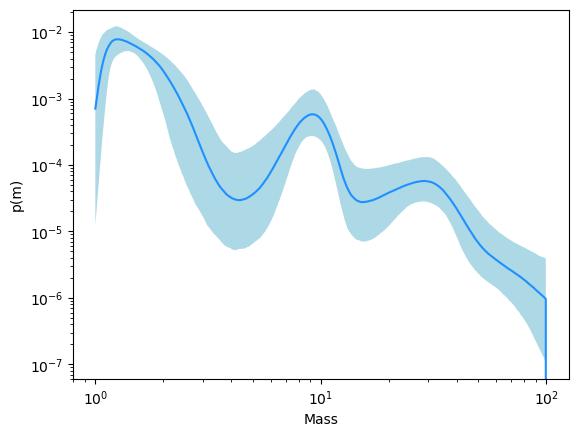

In [9]:
# Functional form checked
plt.figure()
p50 = np.percentile(prob_mass, 50, axis=0)
p95 = np.percentile(prob_mass, 95, axis=0)
p5 = np.percentile(prob_mass, 5, axis=0)
plt.fill_between(mass_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(mass_grid, p50.squeeze(), color="dodgerblue")
plt.xscale("log");plt.yscale("log")
plt.xlabel("Mass")
plt.ylabel("p(m)")
plt.show()

/var/folders/hr/fxn20ncj0qq2_mtm8k66bl7r0000gn/T/ipykernel_59199/2784863700.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(joint_mass_grid, joint_mass_grid, p_joint, levels=levs, cmap="viridis", norm=mpl.colors.LogNorm())


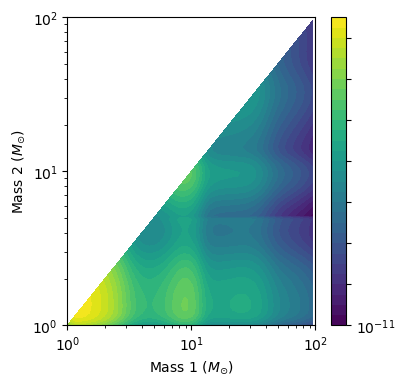

In [10]:
p_joint = np.median(prob_joint_mass, axis=0).reshape(len(joint_mass_grid), len(joint_mass_grid)).T

plt.figure(figsize=(4,4))
levs = np.geomspace(1e-11, 2e-2, num=31, endpoint = True).tolist()
plt.contourf(joint_mass_grid, joint_mass_grid, p_joint, levels=levs, cmap="viridis", norm=mpl.colors.LogNorm())
plt.xscale("log") ; plt.yscale("log")
plt.xlabel(r"Mass 1 ($M_{\odot}$)") ; plt.ylabel(r"Mass 2 ($M_{\odot}$)")
plt.colorbar()
plt.show()

Text(0, 0.5, 'p(a)')

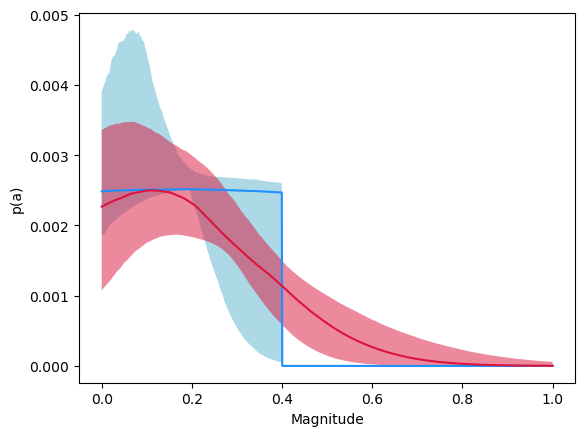

In [11]:
plt.figure()
p50 = np.percentile(p_mag_NS, 50, axis=0)
p95 = np.percentile(p_mag_NS, 95, axis=0)
p5 = np.percentile(p_mag_NS, 5, axis=0)
plt.fill_between(mag_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(mag_grid, p50.squeeze(), color="dodgerblue")
p50 = np.percentile(p_mag_BH, 50, axis=0)
p95 = np.percentile(p_mag_BH, 95, axis=0)
p5 = np.percentile(p_mag_BH, 5, axis=0)
plt.fill_between(mag_grid, p5, p95, facecolor="crimson", alpha=0.5)
plt.plot(mag_grid, p50.squeeze(), color="crimson")
plt.xlabel("Magnitude") ; plt.ylabel("p(a)")

In [12]:
# p(cos(theta)) = p(theta) * |dtheta/dcostheta|

jac = lambda tg: np.abs(1/(np.sin(tg))) # Add jitter for stability

costilt_NS = np.array([tilt * jac(tilt_grid) for tilt in tilt_NS])
costilt_BH = np.array([tilt * jac(tilt_grid) for tilt in tilt_BH])
cos_tilt_grid = np.cos(tilt_grid)
assert np.isclose(cos_tilt_grid.min(), -1)
assert np.isclose(cos_tilt_grid.max(), 1)

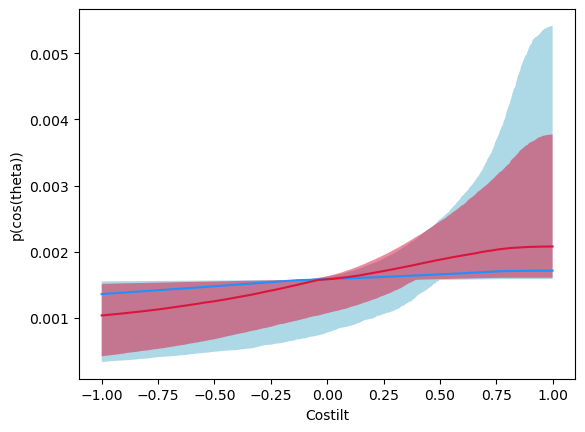

In [13]:
plt.figure()
p50 = np.percentile(costilt_NS, 50, axis=0)
p95 = np.percentile(costilt_NS, 95, axis=0)
p5 = np.percentile(costilt_NS, 5, axis=0)
plt.fill_between(cos_tilt_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(cos_tilt_grid, p50.squeeze(), color="dodgerblue")
p50 = np.percentile(costilt_BH, 50, axis=0)
p95 = np.percentile(costilt_BH, 95, axis=0)
p5 = np.percentile(costilt_BH, 5, axis=0)
plt.fill_between(cos_tilt_grid, p5, p95, facecolor="crimson", alpha=0.5)
plt.plot(cos_tilt_grid, p50.squeeze(), color="crimson")
plt.xlabel("Costilt") ; plt.ylabel("p(cos(theta))")
plt.show()